# Logistic Regression (from scratch)


## 1) Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## 2) Parameters
Change these and re-run the relevant cells below.

In [2]:
# ---- Parameters ----
DATA_PATH = 'loan_data.csv'   # Path to your CSV
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Optimizer-specific defaults (you can override later or via widgets)
BGD_LEARNING_RATE = 0.1
BGD_EPOCHS = 1000

ADAM_LEARNING_RATE = 0.01
ADAM_EPOCHS = 1000
ADAM_BETA1 = 0.9
ADAM_BETA2 = 0.999
ADAM_EPSILON = 1e-8

## 3) From‑Scratch Logistic Regression Class

In [3]:
# --- 1. The Logistic Regression Model Class ---

class LogisticRegression:
    """
    A from-scratch implementation of Logistic Regression with two optimizers:
    1. Batch Gradient Descent (BGD)
    2. Adam Optimizer
    """
    
    def __init__(self, learning_rate=0.01, n_epochs=1000, 
                 beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weights = None
        self.bias = None
        self.cost_history = []

    def _sigmoid(self, z):
        z_clipped = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z_clipped))

    def _initialize_params(self, n_features):
        self.weights = np.zeros(n_features)
        self.bias = 0

    def _compute_cost(self, y_true, y_pred):
        m = y_true.shape[0]
        epsilon = 1e-9
        y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
        cost = -(1/m) * np.sum(
            y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped)
        )
        return cost

    def fit_bgd(self, X, y):
        print("Starting training with Batch Gradient Descent...")
        m_samples, n_features = X.shape
        self._initialize_params(n_features)
        self.cost_history = []
        
        for i in range(self.n_epochs):
            linear_model = X @ self.weights + self.bias
            y_pred = self._sigmoid(linear_model)
            cost = self._compute_cost(y, y_pred)
            self.cost_history.append(cost)
            dw = (1 / m_samples) * (X.T @ (y_pred - y))
            db = (1 / m_samples) * np.sum(y_pred - y)
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            if (i+1) % 100 == 0:
                print(f"BGD Epoch {i+1}/{self.n_epochs}, Cost: {cost:.4f}")

    def fit_adam(self, X, y):
        print("Starting training with Adam Optimizer...")
        m_samples, n_features = X.shape
        self._initialize_params(n_features)
        self.cost_history = []
        m_w, v_w, m_b, v_b = 0, 0, 0, 0
        
        for i in range(self.n_epochs):
            t = i + 1 
            linear_model = X @ self.weights + self.bias
            y_pred = self._sigmoid(linear_model)
            cost = self._compute_cost(y, y_pred)
            self.cost_history.append(cost)
            dw = (1 / m_samples) * (X.T @ (y_pred - y))
            db = (1 / m_samples) * np.sum(y_pred - y)
            m_w = self.beta1 * m_w + (1 - self.beta1) * dw
            m_b = self.beta1 * m_b + (1 - self.beta1) * db
            v_w = self.beta2 * v_w + (1 - self.beta2) * (dw**2)
            v_b = self.beta2 * v_b + (1 - self.beta2) * (db**2)
            m_w_corr = m_w / (1 - self.beta1**t)
            m_b_corr = m_b / (1 - self.beta1**t)
            v_w_corr = v_w / (1 - self.beta2**t)
            v_b_corr = v_b / (1 - self.beta2**t)
            self.weights -= self.learning_rate * m_w_corr / (np.sqrt(v_w_corr) + self.epsilon)
            self.bias -= self.learning_rate * m_b_corr / (np.sqrt(v_b_corr) + self.epsilon)
            if (i+1) % 100 == 0:
                print(f"Adam Epoch {i+1}/{self.n_epochs}, Cost: {cost:.4f}")

    def predict_proba(self, X):
        linear_model = X @ self.weights + self.bias
        return self._sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        probas = self.predict_proba(X)
        return (probas >= threshold).astype(int)

## 4) Helper Functions

In [4]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Rejected (0)', 'Approved (1)'],
                yticklabels=['Rejected (0)', 'Approved (1)'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def evaluate_and_report(model_name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    print(f"\n{model_name} Accuracy: {acc:.4f}")
    print(f"{model_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Rejected (0)', 'Approved (1)']))
    return acc

## 5) Load Data

In [6]:
# Make sure DATA_PATH points to your CSV.
try:
    data = pd.read_csv(r"C:\\Sarvesh\\Mtech\\Foundation of Data Engineering\\Assignments\\EX 13\\loan_data.csv")
except FileNotFoundError:
    raise FileNotFoundError("Error: '{r'C:\\Sarvesh\\Mtech\\Foundation of Data Engineering\\Assignments\\EX 13\\loan_data.csv'}' not found. Place it next to this notebook or update DATA_PATH.")

print('Data loaded successfully. Shape:', data.shape)
# Drop rows with missing target
data.dropna(subset=['loan_status'], inplace=True)
X = data.drop('loan_status', axis=1)
y = data['loan_status'].values

print('Preview features:')
display(X.head(3))
print('Preview target:')
display(pd.Series(y).head(3))

Data loaded successfully. Shape: (45000, 14)
Preview features:


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No


Preview target:


0    1
1    0
2    1
dtype: int64

## 6) Build Preprocessing Pipelines

In [7]:
numeric_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include='object').columns
print(f"Numerical features: {list(numeric_features)}")
print(f"Categorical features: {list(categorical_features)}")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

Numerical features: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']
Categorical features: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']


## 7) Train/Test Split & Transform

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

print('Fitting preprocessor and transforming training data...')
X_train_processed = preprocessor.fit_transform(X_train)

print('Transforming test data...')
X_test_processed = preprocessor.transform(X_test)

if not isinstance(X_train_processed, np.ndarray):
    X_train_processed = X_train_processed.toarray()
    X_test_processed = X_test_processed.toarray()

print('Preprocessing complete. Shapes:', X_train_processed.shape, X_test_processed.shape)

Training set size: 36000
Test set size: 9000
Fitting preprocessor and transforming training data...
Transforming test data...
Preprocessing complete. Shapes: (36000, 27) (9000, 27)


## 8) Train — Batch Gradient Descent (BGD)

In [9]:
model_bgd = LogisticRegression(learning_rate=BGD_LEARNING_RATE, n_epochs=BGD_EPOCHS)
model_bgd.fit_bgd(X_train_processed, y_train)

Starting training with Batch Gradient Descent...
BGD Epoch 100/1000, Cost: 0.3134
BGD Epoch 200/1000, Cost: 0.2761
BGD Epoch 300/1000, Cost: 0.2605
BGD Epoch 400/1000, Cost: 0.2518
BGD Epoch 500/1000, Cost: 0.2462
BGD Epoch 600/1000, Cost: 0.2423
BGD Epoch 700/1000, Cost: 0.2394
BGD Epoch 800/1000, Cost: 0.2372
BGD Epoch 900/1000, Cost: 0.2354
BGD Epoch 1000/1000, Cost: 0.2340


## 9) Evaluate — BGD


BGD Model Accuracy: 0.8982
BGD Model Classification Report:
              precision    recall  f1-score   support

Rejected (0)       0.93      0.94      0.94      7000
Approved (1)       0.79      0.74      0.76      2000

    accuracy                           0.90      9000
   macro avg       0.86      0.84      0.85      9000
weighted avg       0.90      0.90      0.90      9000



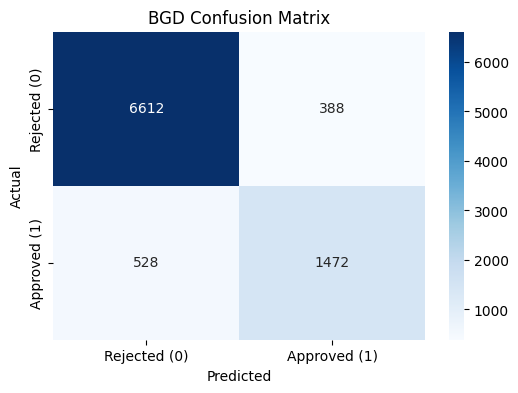

In [10]:
y_pred_bgd = model_bgd.predict(X_test_processed)
acc_bgd = evaluate_and_report('BGD Model', y_test, y_pred_bgd)
plot_confusion_matrix(y_test, y_pred_bgd, 'BGD Confusion Matrix')

## 10) Train — Adam Optimizer

In [11]:
model_adam = LogisticRegression(
    learning_rate=ADAM_LEARNING_RATE, 
    n_epochs=ADAM_EPOCHS, 
    beta1=ADAM_BETA1, beta2=ADAM_BETA2, epsilon=ADAM_EPSILON
)
model_adam.fit_adam(X_train_processed, y_train)

Starting training with Adam Optimizer...
Adam Epoch 100/1000, Cost: 0.2927
Adam Epoch 200/1000, Cost: 0.2544
Adam Epoch 300/1000, Cost: 0.2402
Adam Epoch 400/1000, Cost: 0.2332
Adam Epoch 500/1000, Cost: 0.2295
Adam Epoch 600/1000, Cost: 0.2274
Adam Epoch 700/1000, Cost: 0.2261
Adam Epoch 800/1000, Cost: 0.2252
Adam Epoch 900/1000, Cost: 0.2246
Adam Epoch 1000/1000, Cost: 0.2241


## 11) Evaluate — Adam


Adam Model Accuracy: 0.8989
Adam Model Classification Report:
              precision    recall  f1-score   support

Rejected (0)       0.93      0.94      0.94      7000
Approved (1)       0.79      0.74      0.77      2000

    accuracy                           0.90      9000
   macro avg       0.86      0.84      0.85      9000
weighted avg       0.90      0.90      0.90      9000



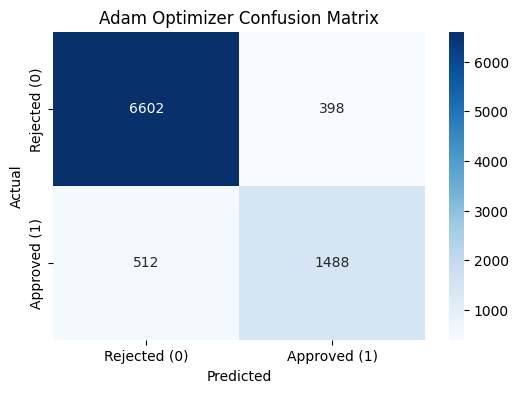

In [12]:
y_pred_adam = model_adam.predict(X_test_processed)
acc_adam = evaluate_and_report('Adam Model', y_test, y_pred_adam)
plot_confusion_matrix(y_test, y_pred_adam, 'Adam Optimizer Confusion Matrix')

## 12) Compare Cost Histories

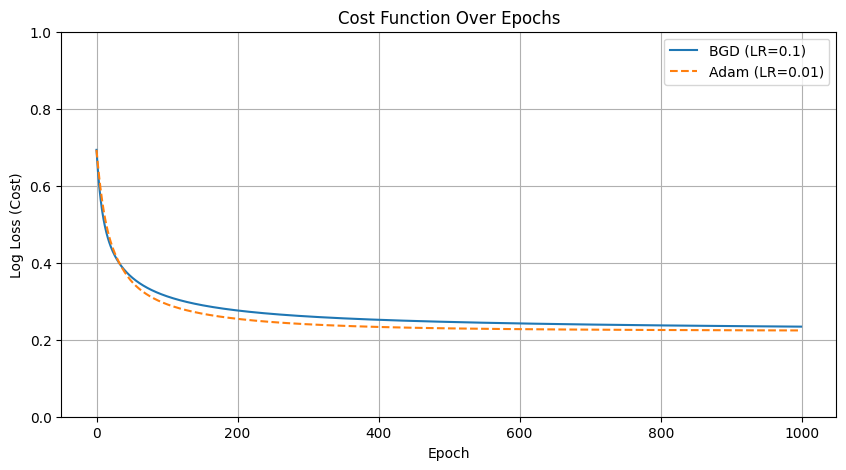

In [13]:
plt.figure(figsize=(10,5))
plt.plot(model_bgd.cost_history, label=f'BGD (LR={BGD_LEARNING_RATE})')
plt.plot(model_adam.cost_history, label=f'Adam (LR={ADAM_LEARNING_RATE})', linestyle='--')
plt.title('Cost Function Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Log Loss (Cost)')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()